<a href="https://colab.research.google.com/github/Raychanan/ray_content_final_project/blob/main/content_final_Word_Embeddings_SUBMIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
e!git clone https://github.com/Raychanan/ray_content_final_project
!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

Cloning into 'ray_content_final_project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 9), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.
  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-6odawkfn
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-6odawkfn
     |████████████████████████████████| 5.5MB 4.0MB/s 
     |████████████████████████████████| 122kB 30.2MB/s 
     |████████████████████████████████| 163kB 40.5MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 133kB 45.5MB/s 
     |████████████████████████████████| 32.8MB 216kB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 5.1MB 44.5MB/s 
     |█████████████████████████

In [ ]:
import pandas as pd
covid_df = pd.read_csv("/content/ray_content_final_project/Corona_NLP_train_utf8.csv", header=0)

covid_df.dropna(inplace=True) # dropna
# now_df.drop("Unnamed: 0", axis=1, inplace=True) # drop column
covid_df.rename(columns={'OriginalTweet':'text', "Sentiment":'sentiment'}, inplace=True) #renmae column

covid_df
covid_df = covid_df.sample(n=5000, random_state=123)

In [ ]:
covid_df.reset_index(drop=True, inplace=True)
covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral
...,...,...,...,...,...,...
4995,34189,79141,"Nottingham, England",06-04-2020,Ready to do work - PC issues.\r\r\nEventually ...,Extremely Positive
4996,17897,62849,Earth,21-03-2020,#RealNews trustworthy #worldnews. \r\r\nEmpty ...,Extremely Negative
4997,21510,66462,"Flagstaff, AZ",23-03-2020,Reminder Lumberjacks Scammers are taking advan...,Extremely Positive
4998,7565,52517,"Brooklyn, New York",18-03-2020,To all of those people who are making it a hab...,Positive


In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [ ]:
#Apply our functions, notice each row is a list of lists now
covid_df['tokenized_sents'] = covid_df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#covid_df['normalized_sents'] = covid_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
covid_df['normalized_sents'] = covid_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

covid_df[:100:10]

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_sents,normalized_sents
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[[Gas, prices, dropping, to, record, lows, wit...","[[gas, price, drop, record, low, place], [covi..."
10,22879,67831,MÃ©xico,24-03-2020,Just 4 winners in our interests with the broad...,Extremely Positive,"[[Just, 4, winners, in, our, interests, with, ...","[[winner, interest, broad, filter, available, ..."
20,30111,75063,Saudi Arabia,02-04-2020,#ecommerce: With the closure of malls and shop...,Neutral,"[[ecommerce, With, the, closure, of, malls, an...","[[ecommerce, closure, mall, shop, coronavirus,..."
30,19699,64651,"Boston, MA",22-03-2020,SOMETHING POSITIVE!!!!!!\r\r\n\r\r\nREDUCED PR...,Extremely Positive,"[[SOMETHING, POSITIVE], [REDUCED, PRICES, DUE,...","[[positive], [reduce, price], [coronavirus, hi..."
40,31017,75969,Scotland,03-04-2020,Beware of fake websites selling products such ...,Neutral,"[[Beware, of, fake, websites, selling, product...","[[beware, fake, website, sell, product, hand, ..."
50,27644,72596,Switzerland,26-03-2020,Take a look on the #trading potential of #EUET...,Negative,"[[Take, a, look, on, the, trading, potential, ...","[[look, trade, potential, euets, -covered, ind..."
60,22075,67027,Buffalo,23-03-2020,It starts the potty training,Neutral,"[[It, starts, the, potty, training]]","[[start, potty, train]]"
70,25851,70803,"Manila, Philippines",25-03-2020,No more vegetables and fruits in a supermarket...,Negative,"[[No, more, vegetables, and, fruits, in, a, su...","[[vegetable, fruit, supermarket, metro, manila..."
80,42083,87035,Barcelona,11-04-2020,Easter distance shopping in a local supermarke...,Neutral,"[[Easter, distance, shopping, in, a, local, su...","[[easter, distance, shop, local, supermarket],..."
90,4534,49486,"Western NC, USA",17-03-2020,Make sure to thank those cashiers store clerks...,Extremely Positive,"[[Make, sure, to, thank, those, cashiers, stor...","[[sure, thank, cashier, store, clerk, stock, c..."


# Word2Vec

We will be using the gensim implementation of Word2Vec

In [ ]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(covid_df['normalized_sents'].sum())

In [ ]:
senReleasesW2V['coronavirus'][:10] #Shortening because it's very large

array([-0.07788546,  0.23184665,  0.35677055,  0.15041505,  0.19928065,
       -0.04078   ,  0.161092  , -0.02154743, -0.18496947,  0.96467084],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

array([[-0.07788546,  0.23184665,  0.35677055, ...,  0.43120974,
        -0.623656  ,  0.19426005],
       [-0.07911733,  0.28313282,  0.3971259 , ...,  0.5210302 ,
        -0.7724243 ,  0.22629239],
       [-0.02551763,  0.1806163 ,  0.33822232, ...,  0.43201858,
        -0.6519749 ,  0.18796502],
       ...,
       [-0.00957031,  0.02099145,  0.02728232, ...,  0.04148355,
        -0.06221373,  0.01758362],
       [-0.0091658 ,  0.02043331,  0.03043408, ...,  0.04085688,
        -0.05350494,  0.01601509],
       [-0.00947722,  0.02640492,  0.04180002, ...,  0.05188848,
        -0.07665376,  0.02118948]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index2word[10]

'consumer'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity)

In [ ]:
senReleasesW2V.most_similar('coronavirus')

[('coronaviruspandemic', 0.9996349811553955),
 ('covid19', 0.9996346831321716),
 ('stayhome', 0.9996170997619629),
 ('covid?19', 0.9995829463005066),
 ('covid_19', 0.9995740652084351),
 ('toiletpaper', 0.9995624423027039),
 ('outbreak', 0.99956214427948),
 ('impact', 0.9995388984680176),
 ('covid2019', 0.999538779258728),
 ('socialdistancing', 0.9995384216308594)]

In [ ]:
senReleasesW2V.most_similar('stayhome')

[('covid2019', 0.9997923374176025),
 ('covid_19', 0.9997614622116089),
 ('lockdown', 0.9997562170028687),
 ('corona', 0.9997357726097107),
 ('virus', 0.9997149705886841),
 ('socialdistancing', 0.9997044205665588),
 ('panicbuying', 0.999696671962738),
 ('covid', 0.9996962547302246),
 ('outbreak', 0.9996954202651978),
 ('economy', 0.9996949434280396)]

Find which word least matches the others within a word set (cosine similarity)

In [ ]:
senReleasesW2V.doesnt_match(['coronavirus', 'toiletpaper', 'stayhome', 'socialdistancing', 'lockdown'])

'coronavirus'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: X + Y - Z = _.

In [ ]:
senReleasesW2V.most_similar(positive=['coronavirus', 'unemployment'], negative = ['stayhome'])

[('low', 0.9993836283683777),
 ('market', 0.999373733997345),
 ('fall', 0.9993493556976318),
 ('consumer', 0.9993453621864319),
 ('drop', 0.9993411302566528),
 ('global', 0.9993350505828857),
 ('business', 0.9993345737457275),
 ('fuel', 0.9993340969085693),
 ('high', 0.9993340969085693),
 ('financial', 0.9993313550949097)]

In [ ]:
senReleasesW2V.most_similar(positive=['coronavirus', 'sad'], negative = ['lockdown'])

[('quarantinelife', 0.9978487491607666),
 ('virus', 0.9977922439575195),
 ('coronaviruspandemic', 0.9977884292602539),
 ('alert', 0.9977514743804932),
 ('tp', 0.9977501630783081),
 ('resident', 0.9977490901947021),
 ('covid', 0.9977463483810425),
 ('covid2019', 0.9977231621742249),
 ('relief', 0.9977182149887085),
 ('currently', 0.9977113008499146)]

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.22509556, -0.19239578,  0.34213814, ...,  0.3855636 ,
        -0.3775742 , -0.06604111],
       [ 0.2769336 , -0.20371996,  0.41710553, ...,  0.46143213,
        -0.46164334, -0.08145674],
       [ 0.22860076, -0.1229328 ,  0.29048708, ...,  0.37305555,
        -0.41224378, -0.07885068],
       ...,
       [ 0.19264886, -0.14792717,  0.31171045, ...,  0.35042402,
        -0.3652924 , -0.07516064],
       [ 0.2187191 , -0.16090876,  0.3395745 , ...,  0.38798168,
        -0.4132447 , -0.08055387],
       [ 0.22945634, -0.16497491,  0.36505762, ...,  0.4273632 ,
        -0.43973932, -0.08583659]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. 

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

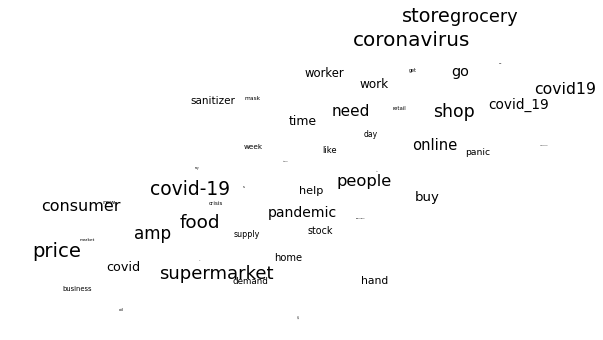

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space.

In [ ]:
keywords = ['coronavirus', 'price', 'store', 'supermarket', 'toiletpaper', 'stayhome', 'food', 'people']

In [ ]:
covid_df['tokenized_words'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_words'] = covid_df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [ ]:
covid_df['TweetAt'].unique()

array(['19-03-2020', '25-03-2020', '24-03-2020', '23-03-2020',
       '21-03-2020', '11-04-2020', '05-04-2020', '31-03-2020',
       '17-03-2020', '20-03-2020', '04-04-2020', '18-03-2020',
       '02-04-2020', '12-04-2020', '08-04-2020', '22-03-2020',
       '01-04-2020', '03-04-2020', '06-04-2020', '26-03-2020',
       '09-04-2020', '10-04-2020', '16-03-2020', '07-04-2020',
       '13-04-2020', '30-03-2020', '27-03-2020', '14-04-2020',
       '28-03-2020', '29-03-2020'], dtype=object)

In [ ]:
covid_df.head()

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_sents,normalized_sents,tokenized_words,normalized_words
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[[Gas, prices, dropping, to, record, lows, wit...","[[gas, price, drop, record, low, place], [covi...","[Gas, prices, dropping, to, record, lows, with...","[gas, prices, dropping, record, lows, place, c..."
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,"[[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID...","[[sale, face, mask, 3ply, n95, rapid, covid-19...","[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID,...","[sale, face, masks, 3ply, n95, rapid, covid-19..."
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,"[[The, impact, of, COVID-19, is, reaching, all...","[[impact, covid-19, reach, way, gas, tank, pri...","[The, impact, of, COVID-19, is, reaching, all,...","[impact, covid-19, reaching, way, gas, tank, p..."
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,"[[3x, as, many, consumers, are, worried, about...","[[3x, consumer, worry, dye, covid-19, lose, jo...","[3x, as, many, consumers, are, worried, about,...","[3x, consumers, worried, dying, covid-19, losi..."
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,"[[How, much, toiletpaper, is, enough], [corona...","[[toiletpaper], [coronavirus, https://t.co/lqs...","[How, much, toiletpaper, is, enough, coronavir...","[toiletpaper, coronavirus, https://t.co/lqszyf..."


In [ ]:
taggedDocs = []
for index, row in covid_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['TweetAt'])
    docKeywords.append(row['ScreenName']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
covid_df['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(covid_df['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
apsD2V.docvecs[1952]

array([ 1.5510643e-03,  3.7019702e-03, -3.2521265e-03, -5.5676199e-05,
       -5.7194473e-05,  4.4091251e-03, -2.5289541e-03,  1.2287864e-03,
        3.3416282e-03,  4.3980759e-03,  9.8308024e-04, -3.6105472e-03,
        1.2139383e-03,  6.9740537e-04,  2.7908199e-03,  5.1206304e-04,
        4.5333775e-03, -3.4290270e-03, -2.1794969e-03,  4.4356696e-03,
        3.9740503e-03,  1.2139265e-03, -4.9218792e-03, -7.7619008e-04,
        4.4545992e-03, -1.5788937e-03, -1.3770328e-03,  2.2346737e-04,
       -1.0708085e-03,  3.7017178e-03,  1.4016007e-03,  2.0059468e-03,
        1.2156810e-03,  2.3337987e-03, -3.4682103e-03,  3.0622745e-03,
        3.7125037e-03, -1.9280039e-03,  3.2738368e-03,  3.4574380e-03,
        1.0836038e-03,  4.4668191e-03,  4.8707621e-03,  2.1906709e-03,
       -4.1297660e-03,  1.5350049e-03,  3.1931527e-04,  2.6628436e-03,
        1.0728720e-04,  3.1221951e-03,  2.6160590e-03,  1.6431265e-03,
       -6.5091276e-04,  4.4163298e-03,  8.9478330e-04, -1.9691272e-03,
      

In [ ]:
apsD2V['covid']

array([ 0.5203094 , -0.13459231,  0.5483521 ,  0.5075996 ,  0.6712351 ,
       -0.31252125,  0.34658852, -0.19988558, -0.70301074,  0.957881  ,
       -0.53870696, -0.2677314 , -0.7003965 , -0.22044122, -0.9424789 ,
        0.03638937, -0.06580419, -0.64746124,  1.006166  , -0.28041613,
       -0.15963604,  0.47409886, -0.28602412,  0.79171777, -0.30006146,
       -0.2005404 , -0.87116313,  0.53456986, -0.44803545,  0.04302767,
        0.0503906 ,  0.06079909,  0.7150134 ,  0.3720215 , -0.9598635 ,
       -0.48881957, -0.79767454,  1.0161115 ,  0.1370377 , -1.4323604 ,
        0.07667222,  0.29226422, -0.602326  , -0.49091783,  0.03631012,
        0.02641086, -0.471163  , -0.63407654,  0.7265314 ,  0.29489926,
        0.2420775 ,  0.39884055, -0.29506558, -0.02511505, -0.41130757,
       -0.11544774, -0.05708534,  0.7822656 , -0.22410733, -0.34332258,
        0.15581371, -0.12117963,  0.25870034,  0.6545253 ,  0.7111109 ,
        0.7262239 ,  0.57849085,  0.5589668 , -0.28153175, -0.39

In [ ]:
apsD2V.most_similar(positive = ['coronavirus','unemployment'], negative = ['stayhome'], topn = 1)

[('increase', 0.9988493323326111)]

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['coronavirus'].reshape(1,-1), apsD2V['stayhome'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.993867]], dtype=float32)

we will calculate the distance between a word and documents in the dataset

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['coronavirus'] ], topn=5 )

[('25-03-2020', 0.9986323118209839),
 ('price', 0.9960528016090393),
 ('22-03-2020', 0.9956979155540466),
 ('23-03-2020', 0.9956698417663574),
 ('27-03-2020', 0.9955006837844849)]

Now let's go the other way around and find words most similar to this document

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['17-03-2020'] ], topn=5) 

[('home', 0.9996941089630127),
 ('customers', 0.9996293187141418),
 ('elderly', 0.999576210975647),
 ('youâ’re', 0.9995210766792297),
 ('sure', 0.9994879364967346)]

We can even look for documents most like a query composed of multiple words

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['coronavirus']+apsD2V['unemployment']+apsD2V['quarantine']], topn=5 )

[('25-03-2020', 0.9995513558387756),
 ('23-03-2020', 0.9978058338165283),
 ('27-03-2020', 0.997733473777771),
 ('22-03-2020', 0.9976514577865601),
 ('09-04-2020', 0.9970622062683105)]

Now let's plot some words and documents against one another with a heatmap

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

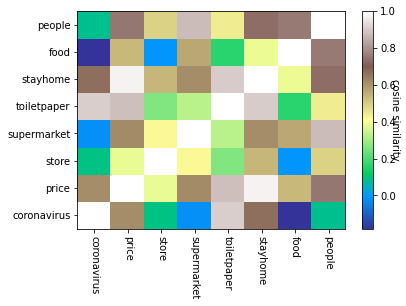

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus

In [ ]:
targetDocs = covid_df['ScreenName'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

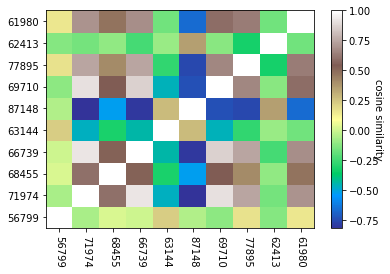

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

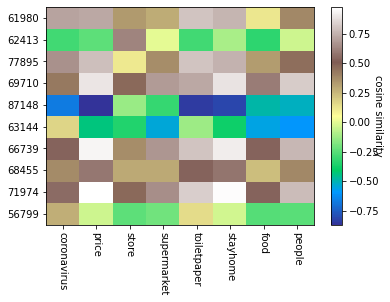

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')